# Plume Analysis Georgia 4x4x1

In [ ]:
CLUSTER ANALYSIS PROJECT TO IDENTIFY PLUMES

In [2]:
%matplotlib inline
%reset -f
import fnmatch
import scipy.optimize as sp
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os 
import glob
from IPython.display import set_matplotlib_formats
from scipy.optimize import curve_fit
import re
import datetime as dt 
import scipy.signal
import matplotlib.ticker as mticker
import math
from IPython.display import display, Latex
import statistics

# %config InlineBackend.figure_formats = ['svg']
plt.rcParams['savefig.dpi'] = 350
plt.rcParams['figure.figsize'] = [4, 4]
plt.rcParams['lines.linewidth'] = 1.5
plt.rcParams['lines.markersize'] = 1.
plt.rcParams['figure.dpi'] = 100

f = mticker.ScalarFormatter(useOffset=False, useMathText=True)
g = lambda x,pos : "${}$".format(f._formatSciNotation('%1.10e' % x))
fmt = mticker.FuncFormatter(g)

In [3]:
def plume_analysis_new(df):
    data_Y=df['Points:1'].values; data_Z=df['Points:2'].values #not height
    dim=int(np.sqrt(len(df['temperature'])))
    T_blocks = np.reshape(df['temperature'].to_numpy(),(dim,dim))
    U_blocks = np.reshape(df['velocity:0'].to_numpy(),(dim,dim))
 
    max_temp=np.max(T_blocks); avg_temp=np.mean(T_blocks); thd_temp=avg_temp+0.2*(max_temp-avg_temp)

    P_blocks=np.zeros((256,256)) #Location of plumes. 1 = plume, 0 = no plume
    P_blocks[:] = np.nan
    T_p_blocks=np.zeros((256,256)) #Only plume temperature. 1 = plume, 0 = no plume
    T_p_blocks[:] = np.nan
    
    da=(data_Y[1]-data_Y[0])**2 #area

    pmf=0; phf=0; plume_temp=[]; plume_cells=0; 

    for i in range(dim-1):
        for j in range(dim-1):
            if (T_blocks[i,j]>=thd_temp) and (U_blocks[i,j]>0):
                plume_cells+=1
                plume_temp.append(T_blocks[i,j])
                P_blocks[i,j]=1
                T_p_blocks[i,j]=T_blocks[i,j]
                pmf+=U_blocks[i,j]*da
                phf+=U_blocks[i,j]*(T_blocks[i,j]-avg_temp)*da

    plume_temp_mean=np.sum(plume_temp)/plume_cells
    maxTp = np.max(plume_temp)
    minTp = np.min(plume_temp)
    sd = statistics.stdev(plume_temp)
    return maxTp, plume_temp_mean, plume_temp, P_blocks, T_p_blocks, dim, minTp, sd

In [49]:
plume_path = '\\Plume Data'

main_path = 'C:\\Users\\super\\Dropbox\\Rice University\\501\\BL-multiple\\'

ra_path = '1e8'
lenRa = 1
Data = pd.DataFrame()

fname = os.path.join(main_path+ra_path+'\\Plume Data','500.csv')
fileL = glob.glob(fname) #list of files
temp = []
for file in fileL:
    a = fileL.index(file)
    b = pd.read_csv(file,header=0)
    b.rename(columns={0:a}, inplace=True)
    temp.append(b)
c = b['temperature'].copy()
c.values[:] = ra_path
temp.append(c)

my_data = pd.concat(temp, axis=1, join="inner",ignore_index=True).drop([2,3,4],axis=1)
my_data.rename(columns={0:'temperature',5:'Points:1',6:'Points:2',7:'Ra',1:'velocity:0'},inplace=True)
Data = pd.concat([Data,my_data],ignore_index=True)
Data['Ra'] = Data['Ra'].astype(float)
Data = Data.sort_values(by=['Ra','Points:2','Points:1'])
Data = Data.reset_index(drop=True)

In [50]:
RaU = Data.Ra.unique()

data = [[] for i in range(lenRa)] #empty nested list

for i in range(lenRa):
    data[i] = Data.loc[Data['Ra'] == RaU[i]]
    data[i] = data[i].reset_index(drop=True)
    
plumeData = pd.DataFrame(columns=['Ra', 'Z', 'T_p'],index=range(0, lenRa))

for i in range(lenRa):
    plumeData.at[i, 'Ra'] = RaU[i]
    pa = plume_analysis_new(data[i])
    plumeData.at[i, 'Z'] = 0.5
    plumeData.at[i, 'T_p'] = pa[1]
    plumeData.at[i, 'max_T_p'] = pa[0]
    plumeData.at[i, 'min_T_p'] = pa[6]
    plumeData.at[i, 'Std. Dev.'] = pa[7]
    dim = pa[5]

# plumeData = plumeData.sort_values(by=['Ra'])
# plumeData = plumeData.reset_index(drop=True) 
plumeData

,Ra,Z,T_p,max_T_p,min_T_p,Std. Dev.
0,100000000.0,0.5,0.674462,0.97058,0.59486,0.073645


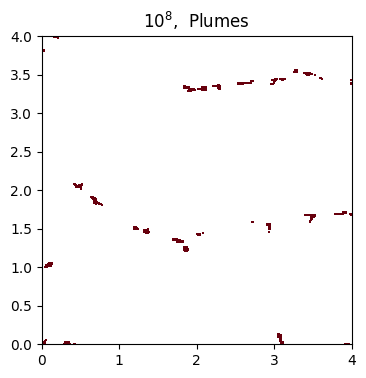

In [51]:
x = np.reshape(data[i]['Points:1'].to_numpy(),(dim,dim))
y = np.reshape(data[i]['Points:2'].to_numpy(),(dim,dim))
plt.pcolormesh(x, y, pa[3], vmin=0,vmax=1, cmap='Reds');
plt.title('{}'.format(fmt(float(RaU[i])))+',  Plumes');
# display(Latex('{}'.format(fmt(float(RaU[i])))))

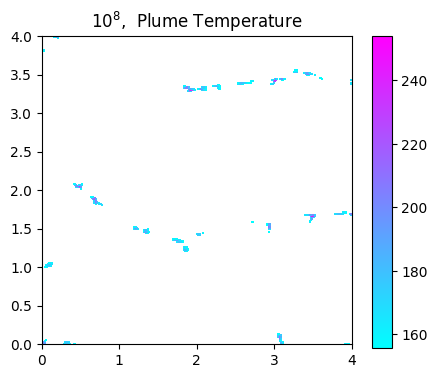

In [52]:
fig = plt.figure(figsize=(4,4))
im = plt.pcolormesh(x, y, pa[4]*deltaT(1e8), cmap='cool');
plt.title('{}'.format(fmt(float(RaU[i])))+',  Plume Temperature');
cb_ax = fig.add_axes([0.95,0.1,.05,0.78])
fig.colorbar(im,orientation='vertical',cax=cb_ax);

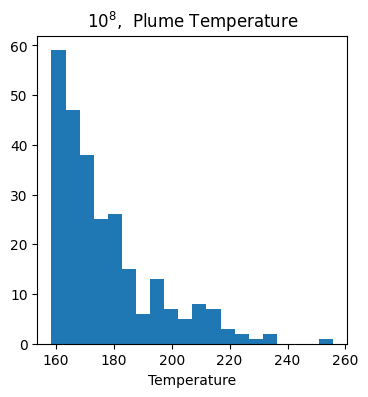

In [40]:
plt.hist(np.array(pa[2])*deltaT(1e8),20);
plt.xlabel('Temperature');
plt.title('{}'.format(fmt(float(RaU[i])))+',  Plume Temperature');
# plt.yscale('log');

In [39]:
np.array(pa[2])

array([0.9778 , 0.71567, 0.68833, 0.72438, 0.67471, 0.62201, 0.65315,
       0.67657, 0.66595, 0.63592, 0.65821, 0.8847 , 0.7985 , 0.67752,
       0.64736, 0.66827, 0.78789, 0.79919, 0.62782, 0.68014, 0.71351,
       0.65524, 0.68863, 0.66592, 0.61316, 0.68982, 0.65969, 0.68928,
       0.6256 , 0.72344, 0.62607, 0.6537 , 0.62632, 0.75684, 0.62998,
       0.617  , 0.68162, 0.79754, 0.69079, 0.66657, 0.74676, 0.70181,
       0.63465, 0.64182, 0.60665, 0.60724, 0.63229, 0.63319, 0.63056,
       0.65993, 0.6329 , 0.62314, 0.63215, 0.6177 , 0.62395, 0.60843,
       0.71683, 0.77816, 0.65326, 0.61067, 0.60667, 0.61692, 0.70362,
       0.70837, 0.62563, 0.61345, 0.6063 , 0.65221, 0.64845, 0.61468,
       0.61371, 0.67468, 0.68065, 0.62162, 0.67313, 0.62753, 0.61789,
       0.68413, 0.69557, 0.63519, 0.65494, 0.60922, 0.63486, 0.6918 ,
       0.69626, 0.63279, 0.6156 , 0.65023, 0.68547, 0.6757 , 0.6121 ,
       0.61738, 0.63628, 0.6504 , 0.62894, 0.62689, 0.60982, 0.64657,
       0.68742, 0.61

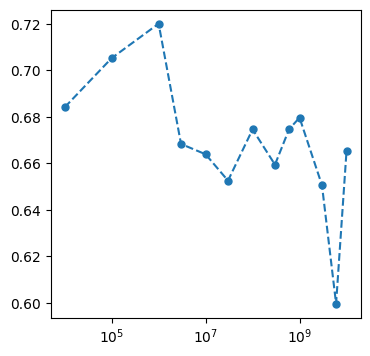

In [201]:
plt.rcParams['lines.markersize'] = 10.
plt.plot(plumeData['Ra'],plumeData['T_p'],'.--')
plt.xscale('log');

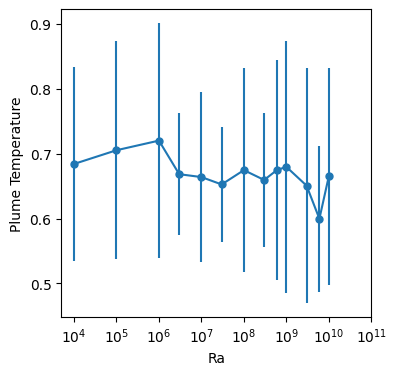

In [202]:
plt.rcParams['lines.markersize'] = 5.
midpoint = (plumeData['max_T_p']+plumeData['min_T_p'])/2
error = [midpoint-plumeData['min_T_p'],plumeData['max_T_p']-midpoint]
plt.errorbar(plumeData['Ra'],plumeData['T_p'], yerr=error, fmt='-o')
plt.xscale('log');
plt.xlabel('Ra')
plt.ylabel('Plume Temperature');
plt.xticks(np.logspace(4,11,num=8));

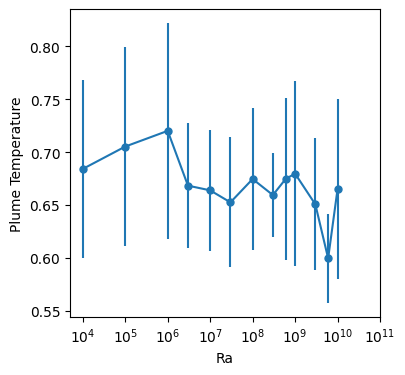

In [203]:
plt.rcParams['lines.markersize'] = 5.
plt.errorbar(plumeData['Ra'],plumeData['T_p'], yerr=plumeData['Std. Dev.'], fmt='-o')
plt.xscale('log');
plt.xlabel('Ra')
plt.ylabel('Plume Temperature');
plt.xticks(np.logspace(4,11,num=8));

In [30]:
R0 = 2870000.0; # m
rho = 3300 # kg/m^3
g = 9.8 # m/s^2
alpha = 5e-5 # 1/K
eta = 10**20 # Pa s
cp = 1250 # J/(kg K)
kappa = 1e-6; # m^2/s
k = kappa*rho*cp; # W/m

In [31]:
def deltaT(Ra):
    tt = (Ra*eta*kappa)/(rho*g*alpha*R0**3)
    return tt

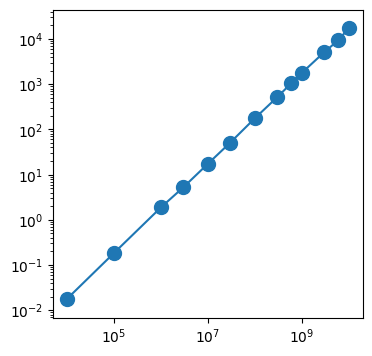

In [212]:
plt.rcParams['lines.markersize'] = 10.
midpoint = deltaT(plumeData['Ra'])*(plumeData['max_T_p']+plumeData['min_T_p'])/2
error = [midpoint-plumeData['min_T_p']*deltaT(plumeData['Ra']),plumeData['max_T_p']*deltaT(plumeData['Ra'])-midpoint]
plt.errorbar(plumeData['Ra'],plumeData['T_p']*deltaT(plumeData['Ra']), yerr=error, fmt='-o')
plt.xscale('log');
plt.yscale('log');

Get the plume temperatures, mean and standard deviation.
Plot Ra in x, mean plume temp in y with std dev error bars or with  min and max

Try to dimensionalize them